# 5 Myths about quantized neural networks
> A post about misconceptions and myths around quantization of neural networks

- toc: false 
- badges: false
- comments: false
- categories: [jupyter, quantization]
- image: images/gpu.jpg
- author: Mathias Lechner

## Background: What are quantized neural networks? 

When we run numerical algorithms on our computer we need to make sacrefices in terms of precision for the sake of runtime. 
For instance, the square root of 2 is an irrational number and has an infinite amount of decimal digits. 
Thus we need to decide how many digits we really need for our application.
Each additional increases the memory and time requirements to store and compute a variable.

For example, the IEEE-754 standard specifies four types of floaint-point formats:

In [32]:
#hide_input
import numpy as np
print("np.sqrt(2):")
print("float128:",str(np.sqrt(np.float128(2))))
print("float64: ",str(np.sqrt(np.float64(2))))
print("float32: ",str(np.sqrt(np.float32(2))))
print("float16: ",str(np.sqrt(np.float16(2))))

np.sqrt(2):
float128: 1.4142135623730950488
float64:  1.4142135623730951
float32:  1.4142135
float16:  1.414


For machine learning applications, the ```float32``` format has been the default choice, as it provides a decent performance while avoiding extreme numerical errors. 
However, in the past decade researcher have made the following two observations:

- During the training phase, certain types of layers can be run and trained with lower precision level (e.g. ```float16```)
- After the training phase (=inference phase), neural networks can run with much lower precision levels without sacreficing much accuracy

Consequently, Nvidia's latest [A100 GPU](https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/nvidia-ampere-architecture-whitepaper.pdf) supports the following six numerical format:

In [2]:
#hide_input
import pandas as pd
import altair as alt
df = pd.DataFrame({'Data type': ["float64"],
        'TOPS': [9.7],
        'Significand precision': ['52-bits'],
        'Exponent': ['11-bits'],
        'Comment': ['Double precision IEE-754 floating-point'],
        })
df = df.append({'TOPS': 19.5,
        'Data type': "float32",
        'Comment': 'Single precision IEE-754 floating-point',
        'Significand precision': '23-bits',
        'Exponent': '8-bits',
        },ignore_index=True)
df = df.append({'TOPS': 156,
        'Data type': "TensorFloat32",
        'Comment': '32-bit floating-point format with reduced significand precision',
        'Significand precision': '10-bits',
        'Exponent': '8-bits',
        },ignore_index=True)
df = df.append({'TOPS': 312,
        'Data type': "float16",
        'Comment': 'Half precision IEE-754 floating-point',
        'Significand precision': '10-bits',
        'Exponent': '5-bits',
        },ignore_index=True)
df = df.append({'TOPS': 312,
        'Data type': "bfloat16",
        'Comment': '16-bit brain-float format with larger range but reduced significand precision',
        'Significand precision': '7-bits',
        'Exponent': '8-bits',
        },ignore_index=True)
df = df.append({'TOPS': 624,
        'Data type': "int8",
        'Comment': '8-bit integer format for fixed-point arithmetic',
        'Significand precision': '7-bits',
        'Exponent': '0-bits',
        },ignore_index=True)
df[['Data type','Comment','Significand precision','Exponent']]

,Data type,Comment,Significand precision,Exponent
0,float64,Double precision IEE-754 floating-point,52-bits,11-bits
1,float32,Single precision IEE-754 floating-point,23-bits,8-bits
2,TensorFloat32,32-bit floating-point format with reduced sign...,10-bits,8-bits
3,float16,Half precision IEE-754 floating-point,10-bits,5-bits
4,bfloat16,16-bit brain-float format with larger range bu...,7-bits,8-bits
5,int8,8-bit integer format for fixed-point arithmetic,7-bits,0-bits


One item that stands out in this list is the last row: While all other formats are based on a floating-point representation, ```int8``` is an integer type.

This raises the question: 

> **How can we run a neural network with integer operations?**

The answer is quantization. 

> Important: Quantization turns a network that operates over floating-point variables into a network that uses fixed-point arithmetic


[Fixed-point arithmetic](https://en.wikipedia.org/wiki/Fixed-point_arithmetic) is a numerical format that can be implemented relatively effeciently used integer operations.
For instance, we can use the first four bits of an ```int8``` value to represent the digits before the comma, and the last four bits to represent fractional digits that come after the comma:

```
0.5       + 1.25      = 1.75
0000.1000 + 0001.0100 = 0001.1100

```

A fixed-point addition can be implemented by simple integer addition and a fixed-point multiplication by a integer multiplication followed by an bit-wise shift operation.

Obviously, the precision achieved with an 8-bit fixed-point format is not enough for training a neural network. However for inferencing, most types of layers can be quantized without suffering a significant loss in accuracy.
The quantization step itself rounds the ```float32``` weight values to their nearest corresponding fixed-point value.

The clear advantages of running a network using ```int8``` is that:

1. It requies less memory, which improves cache and memory bandwidth efficiency.
2. Can run using more efficient integer operations

In particular, a [2017 Google paper](https://arxiv.org/pdf/1704.04760.pdf) writes:

> Eight-bit integer multiplies can be 6X less energy and 6X less area than IEEE 754 16-bit floating-point multiplies, and the
> advantage for integer addition is 13X in energy and 38X in area [Dal16].
> 
> ***- ''In-Datacenter Performance Analysis of a Tensor Processing Unit'' - Jouppi et al.***


Despite this relatively simple concept, there are several misconceptions and myths regarding quantized neural networks:

## Myth #1: Quantization is only necessary for ultra-low-power embedded systems

Far from it. Data center applications currently benefit the most from quantization. 
For instance, the first generation of [Google's Tensor Processing Units (TPUs)](https://arxiv.org/pdf/1704.04760.pdf) only supported 
quantized networks. Support for floating-point arithmetic was only added in the [second generation](https://www.tomshardware.com/news/tpu-v2-google-machine-learning,35370.html).

Likewise, Nvidia's [V100](https://www.microway.com/knowledge-center-articles/in-depth-comparison-of-nvidia-tesla-volta-gpu-accelerators/) and latest [A100](https://www.anandtech.com/show/15801/nvidia-announces-ampere-architecture-and-a100-products) can
perform four times as many ```int8``` tensor operations compared to ```float32``` operations per second (or twice as much ```int8``` as ```float16``` tensor operations per second).
This means that, in a best case scenario, you can **quadruple the throughput of your data center application**
if you quantize your network.

## Myth #2: Quantization makes networks smaller but not faster

As already hinted in the myth above, modern AI accelerators such as GPU and TPU can run integer operations faster than floating-point operations.
Let's have a look at the compute performance of Nvidia's latest [A100 GPU](https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/nvidia-ampere-architecture-whitepaper.pdf):


In [3]:
#hide_input
points = alt.Chart(df).mark_bar().encode(
    alt.X('Data type',sort=list(df['Data type']),axis=alt.Axis(labels=False,title='Data format')),
    y=alt.Y('TOPS',axis=alt.Axis(title="Tera op/s")),
    color=alt.Color('Data type',legend=None,scale=alt.Scale(scheme='dark2')),
    tooltip=['Data type','TOPS','Comment', 'Significand precision','Exponent']
).properties(
    width=700,
    height=300,
    title="Nvidia A100 compute performance"
)

#points
text = points.mark_text(
    align='center',
    fontSize=16,
    baseline='middle',
    dy=-10
).encode(
    text='Data type'
)
points + text

alt.LayerChart(...)

Essentially, quantization does not only make the network smaller, but it also runs faster!

## Myth #3: Any layer in a neural network can be quantized

Some types of layers do not tolerate quantization very well. For example, in [a discussion of an ICLR paper by Max Welling's group](https://openreview.net/forum?id=HkxjYoCqKX&noteId=rygmk1EDT7) we see that quantizing the first or the last layer of a network results an a considerable drop in accuracy. 
This gap does not completely close even if we train the network using quantization-aware training.

One trick which is often used to avoid this drop in accuracy is to not quantize the first and the last layer. 
As these two layers only take up a small fraction of the computations inside a network, running the first and the last layer with ```float32``` does not hurt throughput much, but significantly benefits the accuracy of the network. 

However, one some end-devices this approach is not an option. For instance, [Google's Edge TPU](https://cloud.google.com/edge-tpu) only supports ```int8```. Therefore, in such cases every layer of the network must be quantized to 8-bit integers.

## Myth #4: It's easy to compare different quantization approaches

Comparing two different quantization method is not a trivial job. 
Connecting to the discussion above, let's imagine we have a network and quantize it with two different methods to obtain network A and network B.
While, network A achieves a 90% accuracy by quantized all layers, network B achieves a 92% accuracy but leaves the first layer running with floating-point precision.

Which method is better?

The answer of this question depends on the context; which target device will the network run on?
If it's a device wihtout a floaing-point unit such as the Edge TPU or a microcontroller, then method A is clearly better. 
Contrarily, if we plan to run the network on a V100 or A100 GPU, then method B might be the better approach.

Another technique that causes a lot of misconceptions found in [the discussion of the ICLR paper by Max Welling's group](https://openreview.net/forum?id=HkxjYoCqKX&noteId=rygmk1EDT7) are **non-uniform quantization schemes**:
Fixed-point formats partition the representable value range using a uniform grid, e.g., there are the same amount of intermediate values between 1.5 and 2.5 as between 2.5 and 3.5. 
Looking at the typical weight distribution of neural networks, we notice that they follow a Gaussian-like bell curve distribution with smaller values occurcing more frequently than large weight values. 

In [6]:
#hide
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
num_classes = 10
input_shape = (28, 28, 1)
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
y_train = keras.utils.to_categorical(y_train, num_classes)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=32, epochs=1, validation_split=0.1)


1688/1688 [==============================] - 18s 11ms/step - loss: 0.2303 - accuracy: 0.9289 - val_loss: 0.0575 - val_accuracy: 0.9835


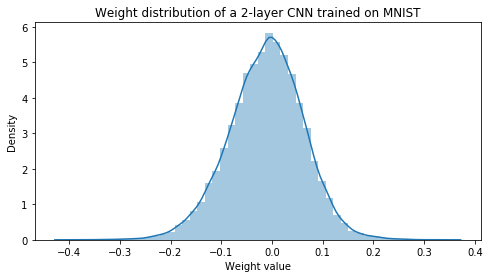

In [31]:
#hide_input

weights = model.get_weights()
weights = [weights[0].flatten(),weights[2].flatten(),weights[4].flatten()]
weights = np.concatenate(weights,axis=0)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.distplot(weights,hist=True,norm_hist=True)
plt.title("Weight distribution of a 2-layer CNN trained on MNIST")
plt.xlabel("Weight value")
plt.ylabel("Density")
plt.show()

If our sole purpose is to represent the weight values as accurately as possible using only 8-bits per parameter, then a logarithmic grid provides a better choice than the uniform partitioning of fixed-point formats.
Although, such non-uniform quantization approaches can compress the weights of the network remarkably well, they destroy the key advantage of quantization: The use of integer arithemtic.

In essence, comparing quantization method can be quite challenging as there are many tradeoffs to be considered. 


## Myth #5: A 8-bit network uses only 8-bit variables

Although the weights and activations of a 8-bit quantized neural network are 8-bit integers, we need 32-bits accumulation registers internally for evaluating the network.


